In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from multiprocessing import Pool
from lampe.data import JointLoader
from itertools import islice
from tqdm import tqdm
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import coverage_plot

#import sys
#sys.path.insert(0, "../scr/cryo_sbi/inference/")
#sys.path.insert(0, "../scr/cryo_sbi/inference/models")
#sys.path.insert(0, "../scr/cryo_sbi/wpa_simulator/")

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_name = '23_03_09_results'    # File name 
data_dir = "../experiments/benchmark_hsp90/results/raw_results/"
plot_dir = "../experiments/benchmark_hsp90/results/plots/"
config_dir = "../experiments/benchmark_hsp90/"
num_samples_stats = 20000           # Number of simulations for computing posterior stats
num_samples_SBC = 10000             # Number of simulations for SBC
num_posterior_samples_SBC = 4096    # Number of posterior samples for each SBC simulation
num_samples_posterior = 50000       # Number of samples to draw from posterior
batch_size_sampling = 100           # Batch size for sampling posterior
num_workers = 24                    # Number of CPU cores
device = 'cuda'                     # Device for computations
save_data = False
save_figures = False

In [3]:
results_fig2b = torch.load("../experiments/benchmark_hsp90/results/raw_data/23_03_15_final_posterior_snr01_examples.pt")

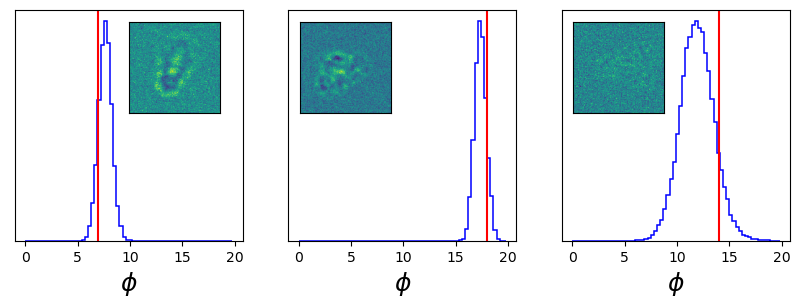

In [8]:
fig , axes = plt.subplots(1, 3, figsize=(10, 3))
idxs = [7, 18, 14]
inset_x = [0.5, 0.05, 0.05]
for idx, ax in enumerate(axes):
    ax.hist(
        results_fig2b['posterior_samples'][:, idxs[idx]].flatten().numpy(),
        bins=np.arange(0, 20, 0.3),
        histtype="step",
        color="blue",
        linewidth=1.1
    )
    ax.set_yticks([])
    ax.set_xlabel(r'$\phi$', fontsize=18)
    ax.axvline(results_fig2b['indices'][idxs[idx]], color='red')
    ax_inset = ax.inset_axes((inset_x[idx], 0.30, 0.4, 0.90))
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.imshow(results_fig2b["images"][idx])

if save_figures:
    plt.savefig('../data/trained_posteriors/benchmark_hsp90/results/plots/fig1_b.pdf', dpi=400, bbox_inches='tight')

In [5]:
del results_fig2b

In [6]:
results_fig2c = torch.load("../experiments/benchmark_hsp90/results/raw_data/23_03_15_final_posterior_stats.pt")

In [7]:
mean_distance = (results_fig2c['posterior_samples'].mean(dim=0) - results_fig2c['indices'].reshape(-1)).numpy()
posterior_quantiles = np.quantile(results_fig2c['posterior_samples'].numpy(), [0.025, 0.975], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

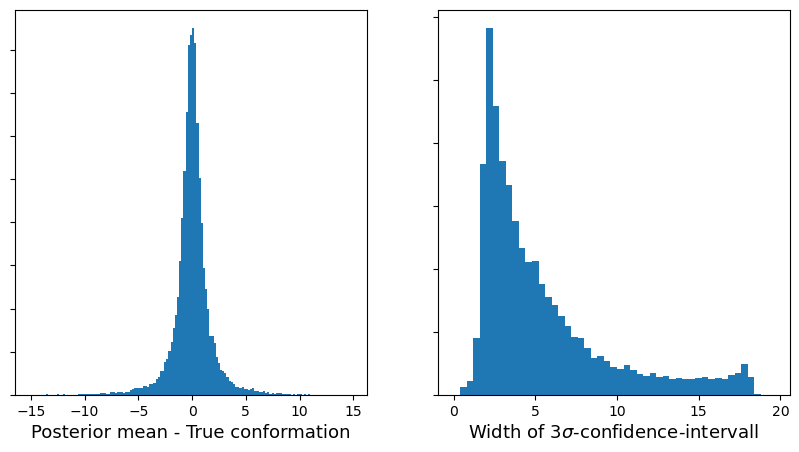

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
_ = ax1.hist(mean_distance, bins=np.arange(-15, 15, 0.2), density=True)
_ = ax2.hist(confidence_widths, bins=np.arange(0, 20, 0.4), density=True)
ax1.set_xlabel('Posterior mean - True conformation', fontsize=13)
ax2.set_xlabel(r'Width of 3$\sigma$-confidence-intervall', fontsize=13)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
if save_figures:
    fig.savefig('../data/trained_posteriors/benchmark_hsp90/results/plots/fig1_c.pdf')

In [ ]:
del results_fig2c

In [9]:
results_fig2d = torch.load("../experiments/benchmark_hsp90/results/raw_data/23_03_15_final_posterior_quats.pt")
quats = np.load('../notebooks/quaternion_list.npy')

In [10]:
mean_distance = (results_fig2d['posterior_samples'].mean(dim=0) - results_fig2d['indices'].reshape(-1)).numpy()
posterior_quantiles = np.quantile(results_fig2d['posterior_samples'].numpy(), [0.025, 0.975], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

/tmp/ipykernel_179953/2715483482.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


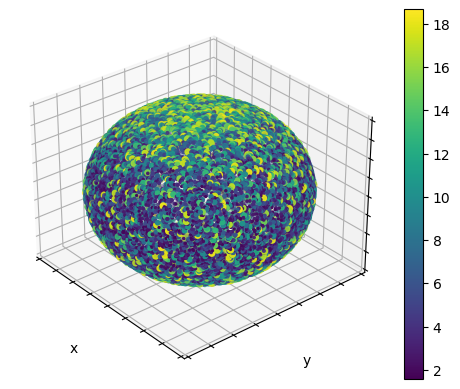

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.transform import Rotation

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

unit_vecotr = np.array([0, 0, 1])
points = []
for i in range(len(quats)):
    rot_mat = Rotation.from_quat(quats[i]).as_matrix()
    coord = np.matmul(rot_mat, unit_vecotr)
    points.append(coord)
points = np.array(points)

xx = points[:, 0]
yy = points[:, 1]
zz = points[:, 2]

#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_surface(
#    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

im = ax.scatter(xx, yy, zz, s=confidence_widths, c=confidence_widths)

ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('z')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.azim = -40
ax.elev = 30
ax.dist = 10

fig.colorbar(im)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("auto")
plt.tight_layout()
plt.show()
#plt.savefig("rotation_posterior_widths_snr001_widres50_128x128.pdf", dpi=600)

In [12]:
def asSpherical(xyz):
    x       = xyz[0]
    y       = xyz[1]
    z       = xyz[2]
    r       =  np.sqrt(x*x + y*y + z*z)
    theta   =  np.arccos(z/r)
    phi     =  np.arctan2(y,x)
    return [r,theta,phi]

coordinates = np.array([asSpherical(point)[1:] for point in points])

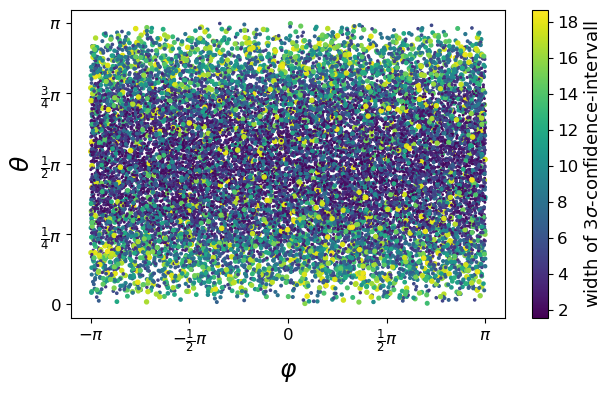

In [13]:
fig , ax = plt.subplots(1, 1, figsize=(7, 4))

scatter_plot = ax.scatter(coordinates[:, 1], coordinates[:, 0], s=0.5*confidence_widths, c=confidence_widths)
cbar = fig.colorbar(scatter_plot)
cbar.set_label(label=r'width of 3$\sigma$-confidence-intervall',size=13)
cbar.ax.tick_params(labelsize=12)
ax.set_ylabel(r'$\theta$', fontsize=18)
ax.set_xlabel(r'$\varphi$', fontsize=18)
ax.set_yticks(
    ticks=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi],
    labels=['0', r'$\frac{1}{4}\pi$', r'$\frac{1}{2}\pi$', r'$\frac{3}{4}\pi$', r'$\pi$'],
    fontsize=12
)
ax.set_xticks(
    ticks=[-np.pi, -np.pi/2 ,0, np.pi/2 ,np.pi],
    labels=[r'$-\pi$', r'$-\frac{1}{2}\pi$', r'0', r'$\frac{1}{2}\pi$', r'$\pi$'],
    fontsize=12
)

if save_figures:
    plt.savefig(f'../../cryo_sbi_experimental/data/trained_posteriors/benchmark_hsp90/results/plots/fig2d.pdf', dpi=400, bbox_inches='tight')